# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass
# Load pickled data
import pickle
import numpy as np
import cv2
import csv
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import tensorflow_hub as hub


training_file = '/train.p'
validation_file = '/valid.p'
testing_file = '/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

TensorFlow 2.x selected.


In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [0]:
test_set = test_set.map(lambda image, label: (tf.image.resize(image, (160, 160)), label))
validation_set = validation_set.map(lambda image, label: (tf.image.resize(image, (160, 160)), label))
train_dataset = train_dataset.map(lambda image, label: (tf.image.resize(image, (160, 160)), label))

In [4]:
print(validation_set)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.uint8)>


---

## Step 1: Dataset Summary & Exploration


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

### Include an exploratory visualization of the dataset

In [5]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape =  (X_test.shape[1],  X_test.shape[1])
n_classes = max(test['labels']) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [0]:
class_names = []
with open('/signnames.csv','rt')as f:
    data = csv.reader(f)
    for row in data:
        sign_name = list(row)[1]
        if(sign_name != 'SignName'):
            class_names.append(sign_name)

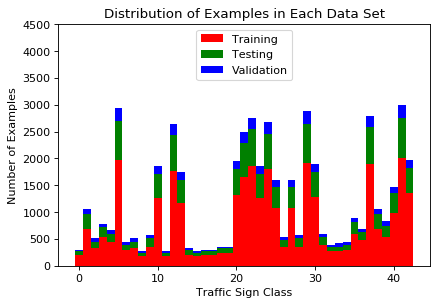

In [7]:
def print_distribution(y_train, y_test, y_valid):
    distribution = {}
    sign_class = []
    sign_num = [[],[],[]]
    
    for image in y_train:
        if(distribution.get(class_names[image]) != None):
            distribution[class_names[image]][0] = distribution[class_names[image]][0] + 1
        else:
            distribution[class_names[image]] = [0,0,0]
            
    for image in y_test:
        if(distribution.get(class_names[image]) != None):
            distribution[class_names[image]][1] = distribution[class_names[image]][1] + 1
        else:
            distribution[class_names[image]] = [0,0,0]
    
    for image in y_valid:
        if(distribution.get(class_names[image]) != None):
            distribution[class_names[image]][2] = distribution[class_names[image]][2] + 1
        else:
            distribution[class_names[image]] = [0,0,0]
            
    for x in distribution:
        sign_class.append(x)
        sign_num[0].append(distribution[x][0])
        sign_num[1].append(distribution[x][1])
        sign_num[2].append(distribution[x][2])
        
    n_classes = range(len(sign_class))
    width = 1
    plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
    p1 = plt.bar(n_classes, sign_num[0], width, color='r')
    p2 = plt.bar(n_classes, sign_num[1], width, bottom=sign_num[0], color='g')
    p3 = plt.bar(n_classes, sign_num[2], width, 
             bottom=np.array(sign_num[0])+np.array(sign_num[1]), color='b')
    plt.ylabel('Number of Examples')
    plt.xlabel('Traffic Sign Class')
    plt.title('Distribution of Examples in Each Data Set')
    plt.ylim([0,4500])
    plt.legend((p1[0], p2[0], p3[0]), ('Training', 'Testing', 'Validation'), loc='upper center')
    plt.show()
    
print_distribution(y_train, y_test, y_valid)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [8]:
for x,y in train_dataset.take(2):
  print(x.shape,y)

(160, 160, 3) tf.Tensor(41, shape=(), dtype=uint8)
(160, 160, 3) tf.Tensor(41, shape=(), dtype=uint8)


### Model Architecture

In [0]:
URL = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(160, 160, 3))

feature_extractor.trainable = True
model = tf.keras.Sequential([feature_extractor,
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(n_classes, activation='softmax')])

In [0]:
IMAGE_RES = (160, 160)

def format_image(image, label):
  image = np.array([image]/255.0, dtype=np.float64)
  return image , label

BATCH_SIZE = 32
train_batches = train_dataset.shuffle(n_train//4).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.shuffle(n_validation//4).batch(BATCH_SIZE).prefetch(1)
test_batches = test_set.shuffle(n_test//4).batch(BATCH_SIZE).prefetch(1)

## Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [30]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
EPOCHS = 10
history = model.fit(
    x = train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches
)

Train for 1088 steps, validate for 138 steps
Epoch 1/10
1088/1088 [==============================] - 70s 64ms/step - loss: 0.6766 - accuracy: 0.9145 - val_loss: 0.9950 - val_accuracy: 0.8923
Epoch 2/10
1088/1088 [==============================] - 66s 61ms/step - loss: 0.2953 - accuracy: 0.9776 - val_loss: 0.4146 - val_accuracy: 0.9463
Epoch 3/10
1088/1088 [==============================] - 67s 61ms/step - loss: 0.2755 - accuracy: 0.9818 - val_loss: 0.3183 - val_accuracy: 0.9615
Epoch 4/10
1088/1088 [==============================] - 67s 61ms/step - loss: 0.2317 - accuracy: 0.9903 - val_loss: 0.7014 - val_accuracy: 0.9213
Epoch 5/10
1088/1088 [==============================] - 67s 61ms/step - loss: 0.2599 - accuracy: 0.9857 - val_loss: 0.2597 - val_accuracy: 0.9821
Epoch 6/10
1088/1088 [==============================] - 67s 61ms/step - loss: 0.2063 - accuracy: 0.9938 - val_loss: 0.2526 - val_accuracy: 0.9785
Epoch 7/10
1088/1088 [==============================] - 66s 60ms/step - loss: 0

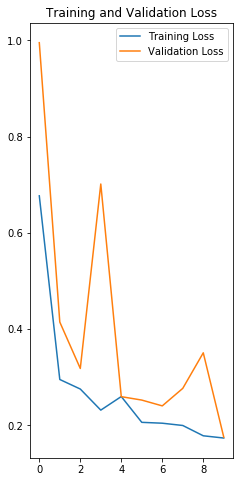

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('/loss.png')
plt.show()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              1343049   
_________________________________________________________________
dense (Dense)                (None, 43)                43086     
Total params: 1,386,135
Trainable params: 1,375,191
Non-trainable params: 10,944
_________________________________________________________________


---

## Step 3: Test a Model on New Images

### Load and Output the Images and Predict the Sign Type for Each Image

Keep right


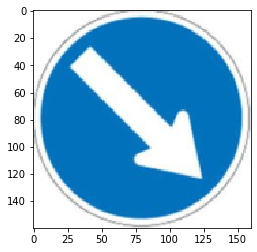

Speed limit (70km/h)


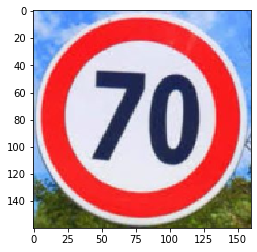

Bumpy road


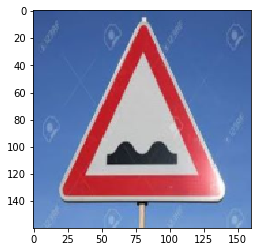

Speed limit (30km/h)


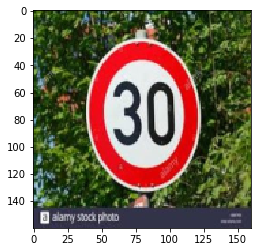

Stop


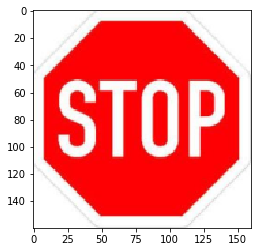

Dangerous curve to the left


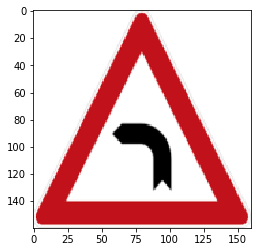

General caution


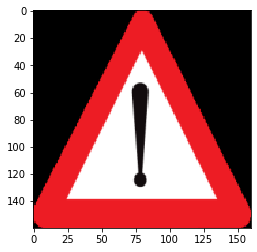

In [33]:
imgs = glob.glob('/*.jpg')
imgs.extend(glob.glob('/*.png'))

for img in imgs:
    cv_image = cv2.imread(img)
    image = cv_image[...,::-1]
    image = cv2.resize(image, (160,160), interpolation = cv2.INTER_AREA)
    arr = np.array([image], dtype=np.float64)
    plt.imshow(image, cmap='binary')
    print(class_names[model.predict(arr).argmax()])
    plt.show()

### Analyze Performance

In [21]:
test_loss, test_accuracy = model.evaluate(test_batches)

395/395 [==============================] - 7s 18ms/step - loss: 0.2398 - accuracy: 0.9660


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [0]:
def print_class_name(array, values):
    print(values)
    for i, elem in enumerate(array):
        print(i+1, class_names[elem], ' ', end="", flush=True)
    print()

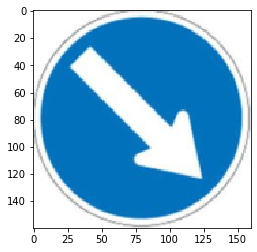

tf.Tensor([0.9752128  0.01369706 0.00472825 0.00121993 0.00102406], shape=(5,), dtype=float32)
1 Keep right  2 Turn left ahead  3 Road work  4 Go straight or right  5 Bicycles crossing  


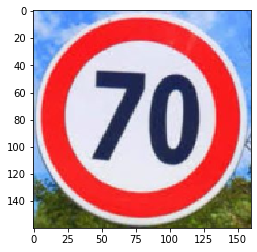

tf.Tensor([0.80616283 0.06361746 0.04680511 0.03402329 0.01488128], shape=(5,), dtype=float32)
1 Speed limit (70km/h)  2 No vehicles  3 Speed limit (120km/h)  4 Speed limit (30km/h)  5 Speed limit (100km/h)  


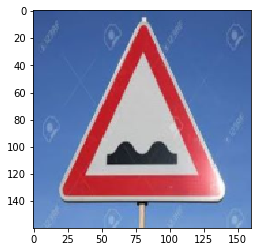

tf.Tensor([1.0000000e+00 4.8886124e-11 3.1331486e-11 1.0742497e-12 1.0431466e-12], shape=(5,), dtype=float32)
1 Bumpy road  2 Dangerous curve to the right  3 Bicycles crossing  4 No passing  5 Yield  


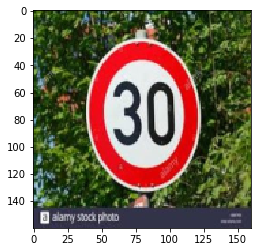

tf.Tensor([9.9895918e-01 7.9446461e-04 1.4741598e-04 3.8256912e-05 1.8724169e-05], shape=(5,), dtype=float32)
1 Speed limit (30km/h)  2 Speed limit (50km/h)  3 Stop  4 Roundabout mandatory  5 Speed limit (80km/h)  


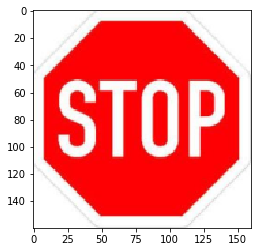

tf.Tensor([1.0000000e+00 8.4348590e-09 1.4923551e-09 1.0518552e-09 1.0271637e-09], shape=(5,), dtype=float32)
1 Stop  2 Speed limit (120km/h)  3 Turn left ahead  4 Speed limit (30km/h)  5 Go straight or left  


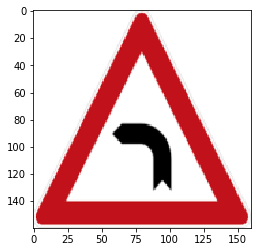

tf.Tensor([9.9902046e-01 8.0710213e-04 7.6185490e-05 5.5524368e-05 2.0012560e-05], shape=(5,), dtype=float32)
1 Dangerous curve to the left  2 Turn left ahead  3 No passing  4 Vehicles over 3.5 metric tons prohibited  5 Dangerous curve to the right  


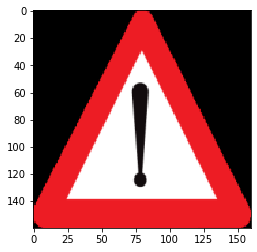

tf.Tensor([1.0000000e+00 3.1402086e-11 3.1169045e-12 1.0231927e-12 9.0640511e-13], shape=(5,), dtype=float32)
1 General caution  2 No vehicles  3 Traffic signals  4 No passing  5 End of speed limit (80km/h)  


In [34]:
imgs = glob.glob('/*.jpg')
imgs.extend(glob.glob('/*.png'))

for i, img in enumerate(imgs):
    cv_image = cv2.imread(img)
    image = cv_image[...,::-1] #convert image to RGB which is our image format
    image = cv2.resize(image, (160,160), interpolation = cv2.INTER_AREA)
    arr = np.array([image], dtype=np.float64)
    prediction = model.predict(arr)
    prediction = tf.squeeze(prediction).numpy()
    values = tf.nn.top_k(tf.constant(prediction), k=5).values
    test = tf.nn.top_k(tf.constant(prediction), k=5).indices
    plt.imshow(image)
    plt.show()
    print_class_name(test, values)

### Project Writeup

Explained in the [README](./README.md)